In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
dataset_train = pd.read_csv('Google_Stock_Price_Train.csv')
dataset_train.head()
dataset_train['Close'] = dataset_train['Close'].str.replace(',', '').astype(float)
dataset_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1258 non-null   object 
 1   Open    1258 non-null   float64
 2   High    1258 non-null   float64
 3   Low     1258 non-null   float64
 4   Close   1258 non-null   float64
 5   Volume  1258 non-null   object 
dtypes: float64(4), object(2)
memory usage: 59.1+ KB


In [4]:
training_set = dataset_train.iloc[:, 1:2].values
print(training_set)
print(training_set.shape)

[[325.25]
 [331.27]
 [329.83]
 ...
 [793.7 ]
 [783.33]
 [782.75]]
(1258, 1)


In [5]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)
training_set_scaled

array([[0.08581368],
       [0.09701243],
       [0.09433366],
       ...,
       [0.95725128],
       [0.93796041],
       [0.93688146]])

In [6]:
X_train = []
Y_train = []
for i in range(60, 1258):
    X_train.append(training_set_scaled[i-60:i, 0])
    Y_train.append(training_set_scaled[i, 0])
X_train, Y_train = np.array(X_train), np.array(Y_train)

In [7]:
print(X_train.shape)
print(Y_train.shape)

(1198, 60)
(1198,)


In [8]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print(X_train.shape)

(1198, 60, 1)


In [9]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

2024-04-01 12:56:37.598449: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
regressor = Sequential()

regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

regressor.add(Dense(units = 1))

In [11]:
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
regressor.fit(X_train, Y_train, epochs = 100, batch_size = 32)

Epoch 1/100
38/38 [==============================] - 14s 104ms/step - loss: 0.0431
Epoch 2/100
38/38 [==============================] - 4s 102ms/step - loss: 0.0078
Epoch 3/100
38/38 [==============================] - 4s 109ms/step - loss: 0.0053
Epoch 4/100
38/38 [==============================] - 4s 110ms/step - loss: 0.0055
Epoch 5/100
38/38 [==============================] - 3s 82ms/step - loss: 0.0051
Epoch 6/100
38/38 [==============================] - 3s 73ms/step - loss: 0.0048
Epoch 7/100
38/38 [==============================] - 3s 71ms/step - loss: 0.0047
Epoch 8/100
38/38 [==============================] - 3s 75ms/step - loss: 0.0043
Epoch 9/100
38/38 [==============================] - 3s 76ms/step - loss: 0.0046
Epoch 10/100
38/38 [==============================] - 3s 73ms/step - loss: 0.0049
Epoch 11/100
38/38 [==============================] - 3s 75ms/step - loss: 0.0044
Epoch 12/100
38/38 [==============================] - 3s 76ms/step - loss: 0.0042
Epoch 13/100
38/38 [

In [12]:
dataset_test = pd.read_csv('Google_Stock_Price_Test.csv')
real_stock_price = dataset_test.iloc[:, 1:2].values

In [17]:
dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values

inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

X_test = []
for i in range(60, 80):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

len(inputs)

80

In [14]:
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
predicted_stock_price

1/1 [==============================] - 2s 2s/step


array([[781.444  ],
       [778.64636],
       [778.7018 ],
       [779.96893],
       [783.26   ],
       [789.2654 ],
       [795.08954],
       [797.9469 ],
       [798.8664 ],
       [798.9478 ],
       [798.71124],
       [798.2098 ],
       [797.6582 ],
       [797.7973 ],
       [798.46375],
       [802.8461 ],
       [809.7922 ],
       [817.55444],
       [822.24994],
       [818.9099 ]], dtype=float32)

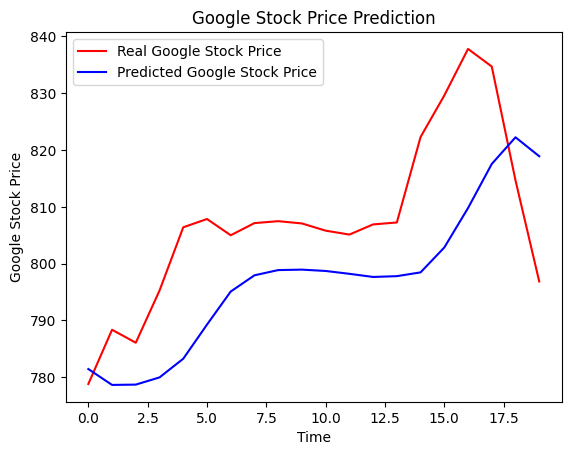

In [18]:
plt.plot(real_stock_price, color = 'red', label = 'Real Google Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()